In [1]:
from __future__ import division, print_function
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from itertools import combinations
import keras.backend as K
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from scipy.spatial.distance import cosine, cdist

from learning2learn.util import get_hidden_representations, similarity
from learning2learn.images import (generate_random_shape, generate_texture, 
                                   get_base_image, generate_image, generate_colors,
                                   add_texture, Texture)

np.random.seed(0)

Using TensorFlow backend.


In [2]:
IMG_SIZE = (224, 224)
model = VGG16(weights='imagenet', include_top=True)
model.layers

In [3]:
def image_gen(shape, color, texture, target_size):
    generate_image(shape, color, texture, save_file='./temp.png')
    # Finally, load the image and return
    img = image.load_img('./temp.png', target_size=target_size)
    img = image.img_to_array(img)
    
    return img

In [4]:
def modHausdorffDistance(itemA, itemB):
    """
    Modified Hausdorff Distance
    
    Input
     itemA : [n x 2] coordinates of "inked" pixels
     itemB : [m x 2] coordinates of "inked" pixels
    
     M.-P. Dubuisson, A. K. Jain (1994). A modified hausdorff distance for object matching.
     International Conference on Pattern Recognition, pp. 566-568.
    """
    
    D = cdist(itemA, itemB)
    mindist_A = D.min(axis=1)
    mindist_B = D.min(axis=0)
    mean_A = np.mean(mindist_A)
    mean_B = np.mean(mindist_B)
    return max(mean_A,mean_B)

def euclidean(x1, x2):
    """
    Euclidean vector distance
    """
    return np.linalg.norm(x1 - x2)

In [45]:
def sample_color(color, var):
    cov = np.array([[var,0,0],[0,var,0],[0,0,var]])
    output = np.random.multivariate_normal(color, cov)
    return np.clip(output, a_min=0.05, a_max=0.95)

def get_feature_similarity_scores(values, nb_categories, distance_fn):
    scores = []
    i_vals = []
    j_vals = []
    for i, j in combinations(range(nb_categories), 2):
        i_vals.append(i)
        j_vals.append(j)
        score = distance_fn(values[i], values[j])
        scores.append(score)
    df = pd.DataFrame()
    df['i'] = i_vals
    df['j'] = j_vals
    df['score'] = scores
    
    return df

def bias_vs_feature_similarity(X_h1, df, X_h2=None):
    df_sorted = df.sort_values(by='score')
    biases = []
    similarities = []
    for k in range(len(df_sorted)):
        pair = df_sorted.iloc[k]
        i = int(pair['i'])
        j = int(pair['j'])
        similarities.append(pair['score'])
        if X_h2 is not None:
            biases.append(similarity(X_h1[i], X_h2[j]))
        else:
            biases.append(similarity(X_h1[i], X_h1[j]))
    
    return biases, similarities

def run_experiment(model, nb_categories, target_feature, others_constant=True, choose_one=False):
    assert target_feature in ['shape', 'color']
    # Choose one of ['ellipse', 'arc', 'arrow', 'circle', 'rectangle', 'wedge', 'pentagon'].
    # The texture will have no gradient for now.
    texture1 = generate_texture('ellipse', gradient=None, image_size=500)
    if target_feature == 'shape':
        # Generate 'nb_categories' random shapes
        values = [np.asarray(generate_random_shape(0, 500, 0, 500, 100)) for _ in range(nb_categories)]
        # Compute similarities between all pairs of shapes
        df = get_feature_similarity_scores(values, nb_categories, distance_fn=modHausdorffDistance)
        # Generate random color(s)
        #other1 = np.random.uniform(0, 1, size=3)
        other1 = np.array([0.31666667, 0.63333333, 0.63333333])
        imgs1 = np.asarray(
            [image_gen(value, other1, texture1, target_size=IMG_SIZE) for value in values]
        )
        if not others_constant:
            texture2 = generate_texture('rectangle', gradient=None, image_size=500)
            #other2 = np.random.uniform(0, 1, size=3)
            other2 = np.array([0.95, 0.31666667, 0.31666667])
            imgs2 = np.asarray(
                [image_gen(value, other2, texture2, target_size=IMG_SIZE) for value in values]
            )
    else:
        # Generate 'nb_categories' random colors
        #values = np.random.uniform(low=0, high=1, size=(N,3))
        values = generate_colors(nb_categories)
        values = np.asarray(
            [sample_color(color, 0.005) for color in values]
        )
        # Compute similaries between all pairs of colors
        df = get_feature_similarity_scores(values, nb_categories, distance_fn=euclidean)
        #df = get_feature_similarity_scores(values, nb_categories, distance_fn=cosine)
        # Generate random shape(s)
        other1 = generate_random_shape(0, 500, 0, 500, 100)
        imgs1 = np.asarray(
            [image_gen(other1, value, texture1, target_size=IMG_SIZE) for value in values]
        )
        if not others_constant:
            texture2 = generate_texture('rectangle', gradient=None, image_size=500)
            other2 = generate_random_shape(0, 500, 0, 500, 100)
            imgs2 = np.asarray(
                [image_gen(other2, value, texture2, target_size=IMG_SIZE) for value in values]
            )
    if choose_one:
        df = df[df.i == 0]
    
    # Compute layer biases
    imgs_h1 = get_hidden_representations(model, preprocess_input(np.copy(imgs1)), layer_num=-4, batch_size=32)
    if others_constant:
        biases, similarities = bias_vs_feature_similarity(imgs_h1, df)
    else:
        imgs_h2 = get_hidden_representations(model, preprocess_input(np.copy(imgs2)), layer_num=-4, batch_size=32)
        biases, similarities = bias_vs_feature_similarity(imgs_h1, df, imgs_h2)
    biases = np.asarray(biases)
    similarities = 1 - minmax_scale(similarities)
        
    if others_constant:
        return imgs1, df, biases, similarities
    else:
        return (imgs1, imgs2), df, biases, similarities

In [31]:
def plot_two(x1, x2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axes[0].imshow(x1 / 255.)
    axes[0].axis('off')
    axes[1].imshow(x2 / 255.)
    axes[1].axis('off')
    plt.show()
    
def show_pair(imgs1, imgs2, df_sorted, k):
    pair = df_sorted.iloc[k]
    i = int(pair['i'])
    j = int(pair['j'])
    score = pair['score']
    print('Distance between #%i and #%i: %0.2f' % (i, j, score))
    plot_two(imgs1[i], imgs2[j])

# Start w/ others_constant=True

## First, try parametrically varying shape

In [27]:
imgs_s, df_s, biases_s, similarities_s = run_experiment(model, 20, target_feature='shape')

In [42]:
lr = LinearRegression()
lr.fit(similarities_s.reshape(-1,1), biases_s)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

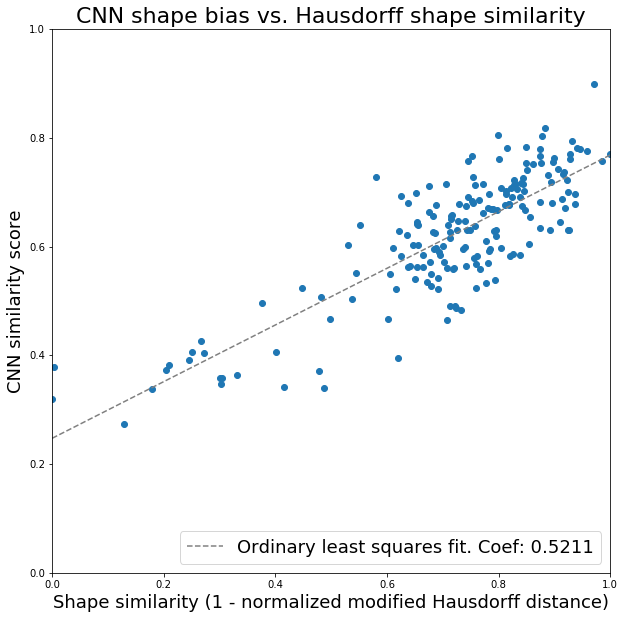

In [43]:
# Plot results
plt.figure(figsize=(10,10))
plt.scatter(similarities_s, biases_s)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('CNN shape bias vs. Hausdorff shape similarity', fontsize=22)
plt.xlabel('Shape similarity (1 - normalized modified Hausdorff distance)', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

Distance between #8 and #10: 36.94


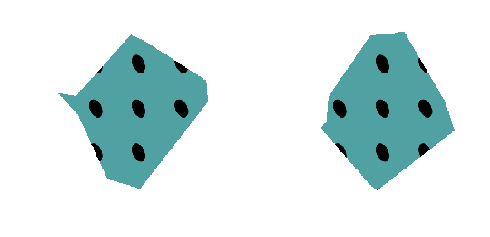

Distance between #9 and #14: 38.90


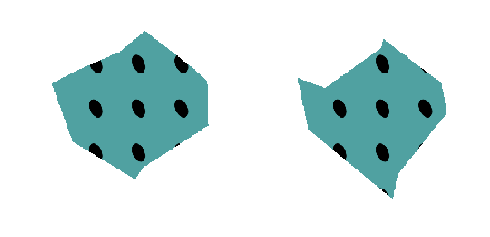

Distance between #0 and #17: 40.68


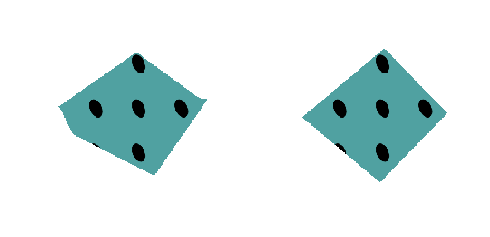

Distance between #0 and #14: 42.28


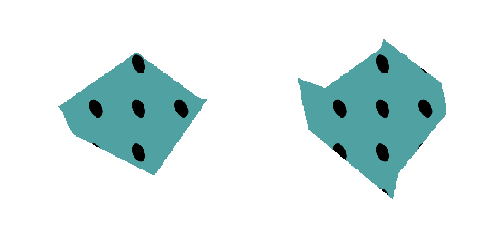

Distance between #8 and #14: 43.79


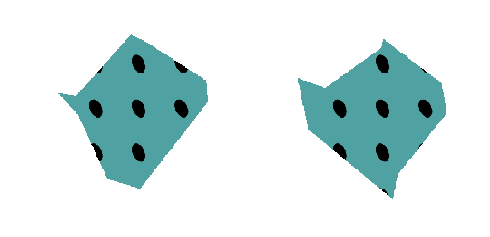




........



Distance between #15 and #17: 138.98


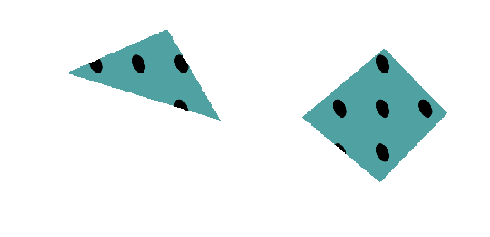

Distance between #11 and #15: 142.15


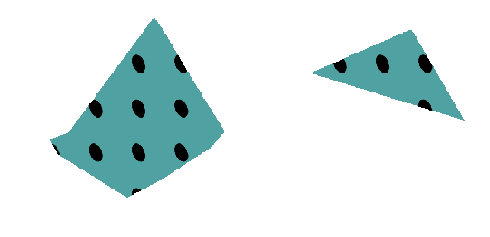

Distance between #15 and #19: 148.50


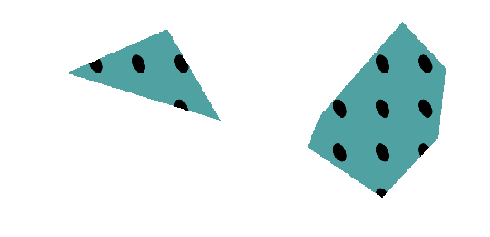

Distance between #2 and #15: 164.74


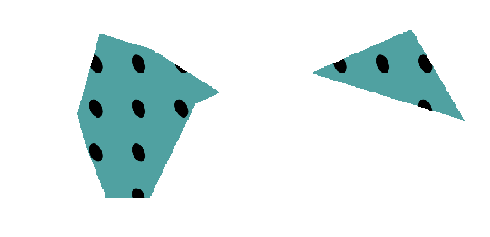

Distance between #6 and #15: 165.06


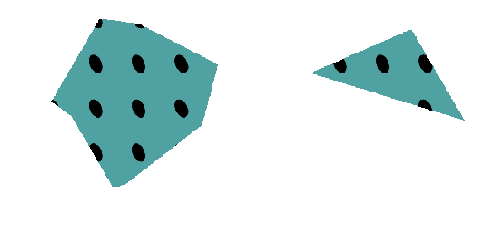

In [32]:
df_sorted = df_s.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:5]:
    show_pair(imgs_s, imgs_s, df_sorted, k)
print('\n\n\n........\n\n\n')
for k in inds[-5:]:
    show_pair(imgs_s, imgs_s, df_sorted, k)

## Now, try parametrically varying color

In [46]:
imgs_c, df_c, biases_c, similarities_c = run_experiment(model, 20, target_feature='color')

In [47]:
lr = LinearRegression()
lr.fit(similarities_c.reshape(-1,1), biases_c)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

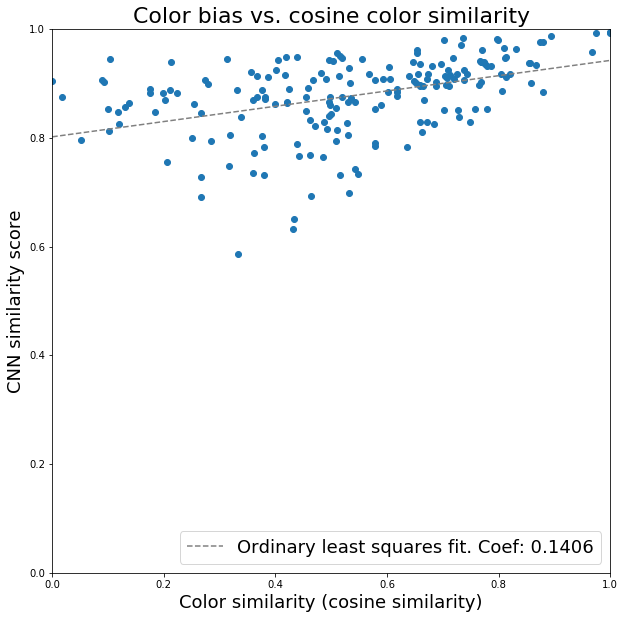

In [48]:
# Plot results
plt.figure(figsize=(10,10))
plt.scatter(similarities_c, biases_c)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('Color bias vs. cosine color similarity', fontsize=22)
plt.xlabel('Color similarity (cosine similarity)', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

Distance between #6 and #13: 0.11


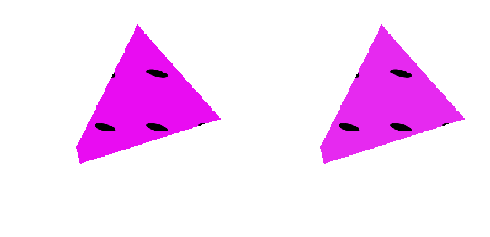

Distance between #3 and #11: 0.11


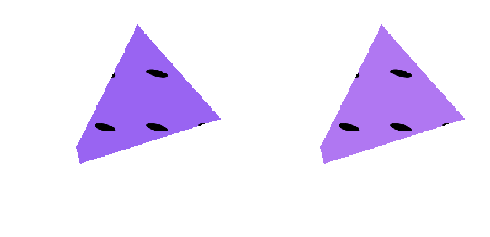

Distance between #0 and #10: 0.14


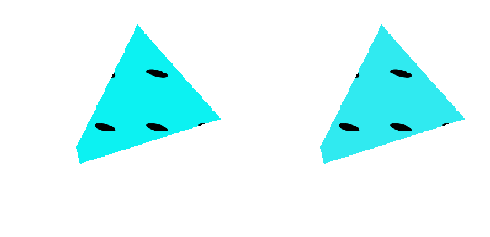

Distance between #17 and #19: 0.15


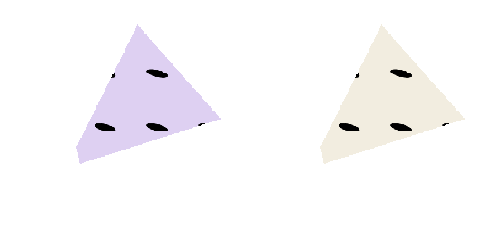

Distance between #5 and #12: 0.24


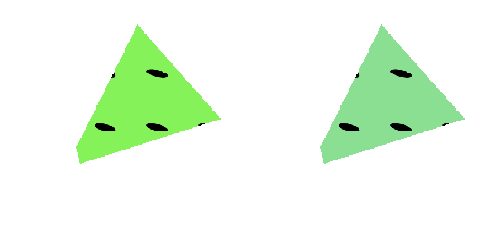




........



Distance between #0 and #13: 1.16


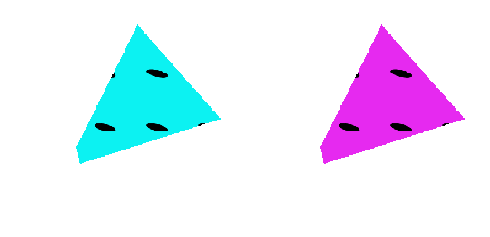

Distance between #9 and #10: 1.17


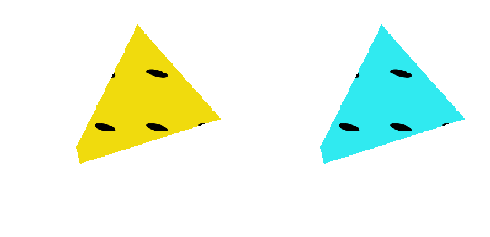

Distance between #6 and #9: 1.21


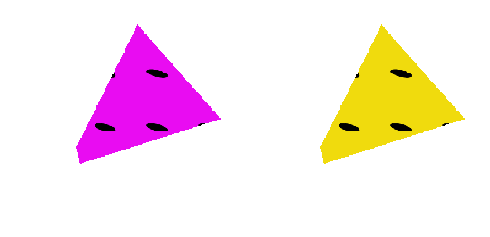

Distance between #0 and #6: 1.25


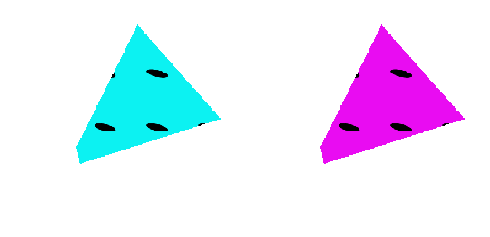

Distance between #0 and #9: 1.27


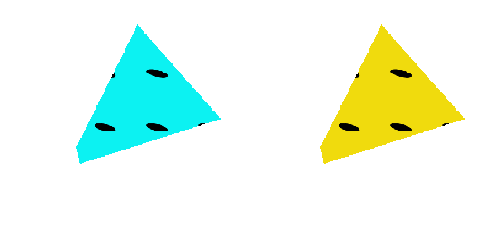

In [49]:
df_sorted = df_c.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:5]:
    show_pair(imgs_c, imgs_c, df_sorted, k)
print('\n\n\n........\n\n\n')
for k in inds[-5:]:
    show_pair(imgs_c, imgs_c, df_sorted, k)

# Let's take a look at the outliers (points w/ very low CNN similarity):

CNN similarity #6 and #19: 0.59


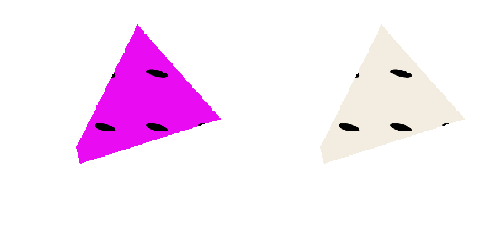

CNN similarity #13 and #19: 0.63


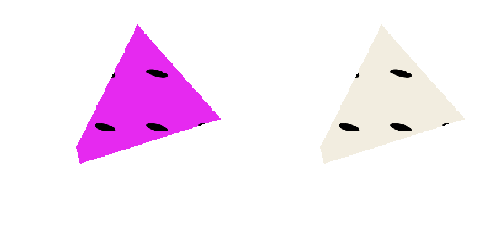

CNN similarity #6 and #17: 0.65


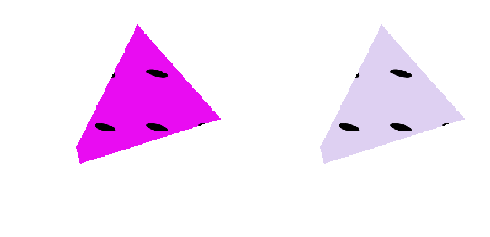

CNN similarity #6 and #18: 0.69


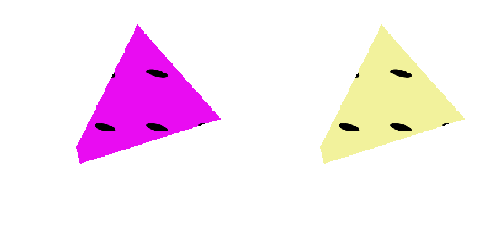

CNN similarity #4 and #6: 0.69


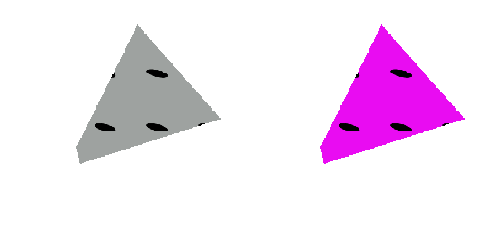

CNN similarity #13 and #17: 0.70


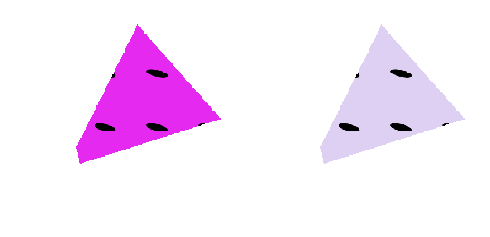

CNN similarity #6 and #16: 0.73


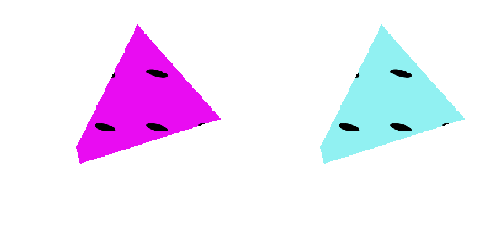

CNN similarity #6 and #8: 0.73


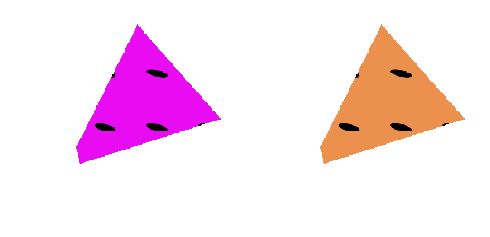

CNN similarity #7 and #19: 0.73


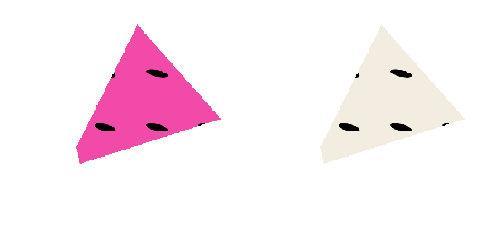

CNN similarity #4 and #13: 0.73


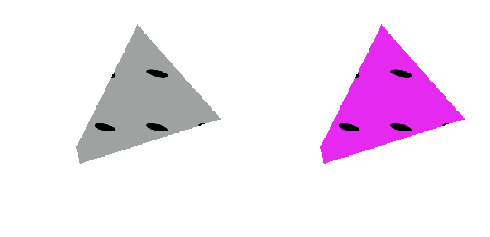

CNN similarity #13 and #18: 0.74


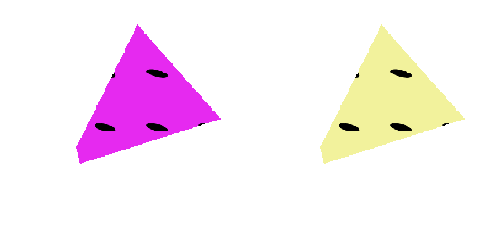

CNN similarity #3 and #19: 0.74


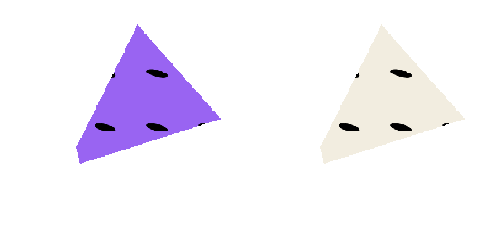

CNN similarity #0 and #19: 0.75


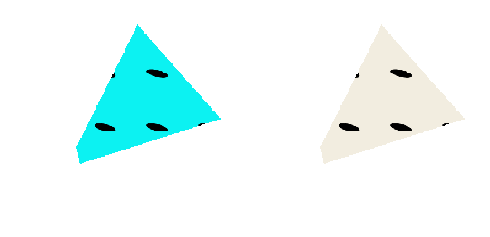

CNN similarity #6 and #15: 0.76


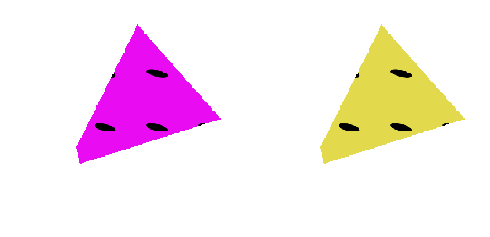

CNN similarity #2 and #19: 0.77


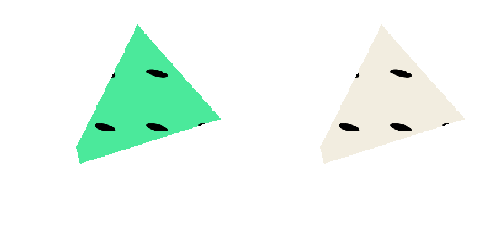

CNN similarity #8 and #13: 0.77


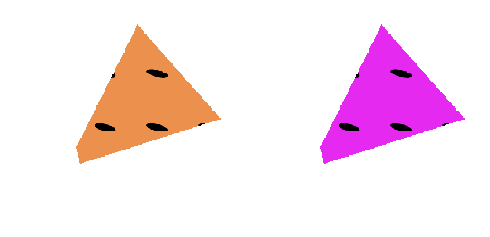

CNN similarity #1 and #6: 0.77


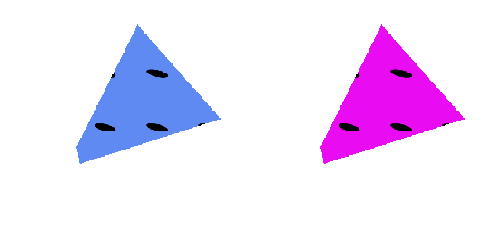

CNN similarity #13 and #16: 0.77


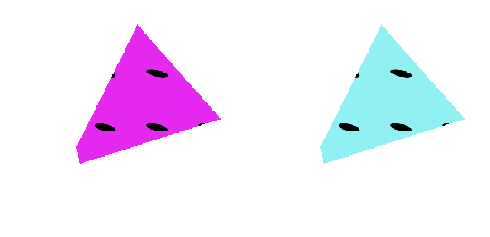

CNN similarity #9 and #19: 0.78


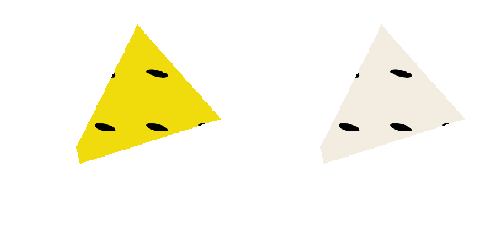

CNN similarity #11 and #19: 0.78


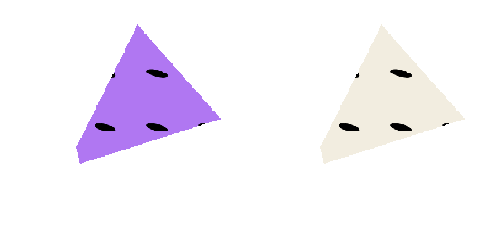

CNN similarity #6 and #14: 0.79


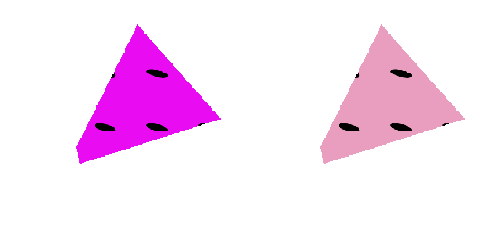

CNN similarity #10 and #19: 0.79


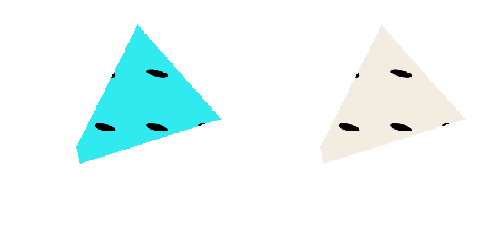

CNN similarity #7 and #17: 0.79


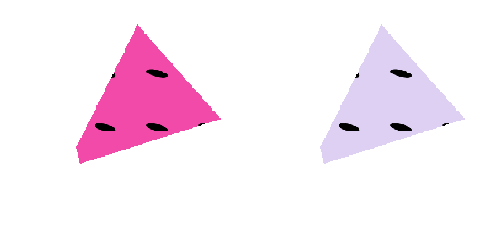

CNN similarity #13 and #15: 0.79


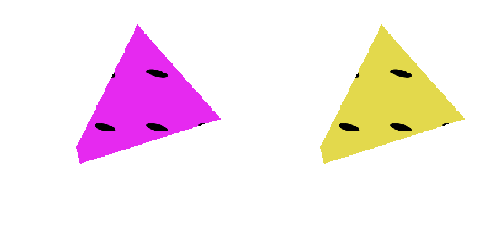

CNN similarity #5 and #19: 0.80


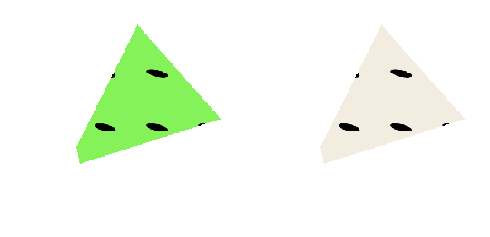

In [50]:
for k, val in sorted(enumerate(biases_c), key=lambda x: x[1])[:25]:
    pair = df_sorted.iloc[k]
    i = int(pair['i'])
    j = int(pair['j'])
    print('CNN similarity #%i and #%i: %0.2f' % (i, j, val))
    plot_two(imgs_c[i], imgs_c[j])

# Move on to others_constant=False

## parametrically vary shape

In [51]:
imgs_s, df_s, biases_s, similarities_s = run_experiment(model, 20, target_feature='shape', others_constant=False)

In [52]:
lr = LinearRegression()
lr.fit(similarities_s.reshape(-1,1), biases_s)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

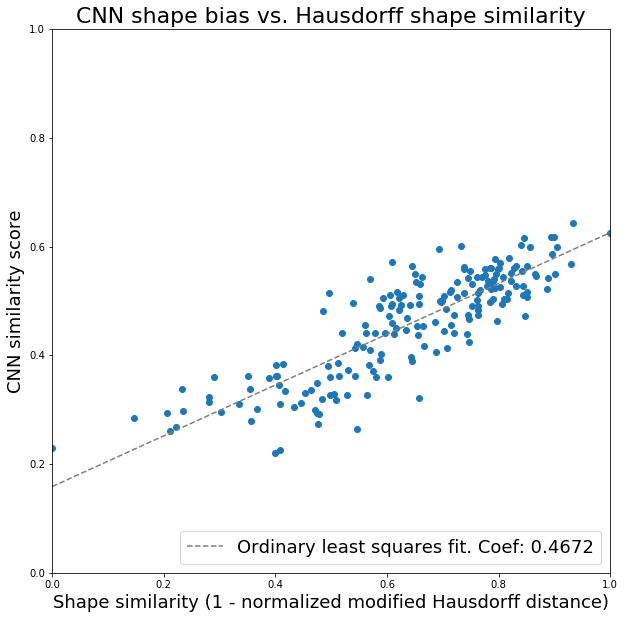

In [54]:
# Plot results
plt.figure(figsize=(10,10))
plt.scatter(similarities_s, biases_s)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('CNN shape bias vs. Hausdorff shape similarity', fontsize=22)
plt.xlabel('Shape similarity (1 - normalized modified Hausdorff distance)', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

Distance between #1 and #6: 32.12


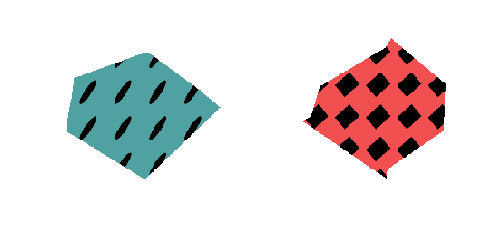

Distance between #1 and #12: 41.29


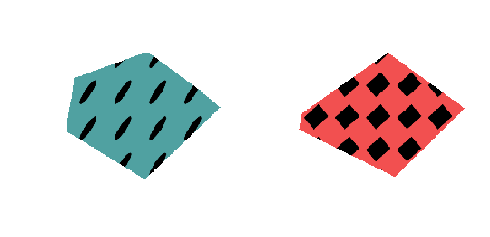

Distance between #3 and #17: 41.89


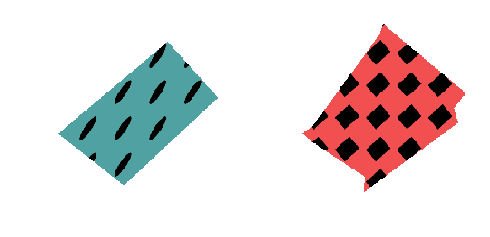

Distance between #0 and #6: 45.36


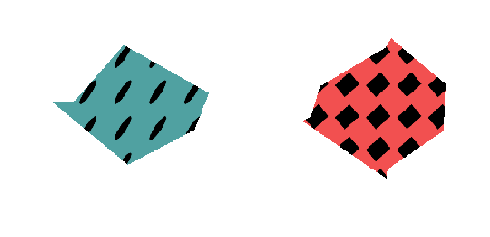

Distance between #5 and #8: 45.69


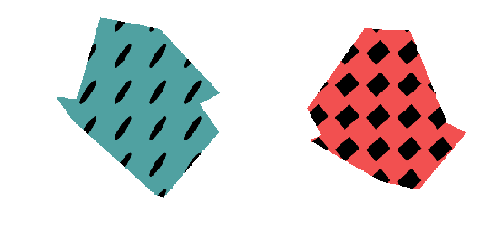




........



Distance between #10 and #17: 139.37


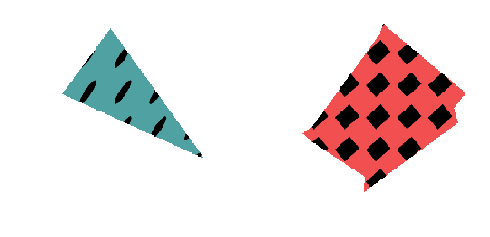

Distance between #2 and #13: 140.74


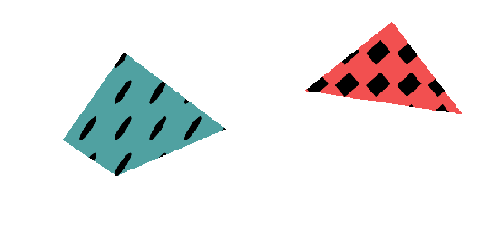

Distance between #10 and #15: 141.63


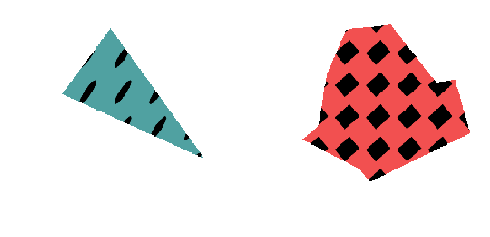

Distance between #10 and #18: 149.73


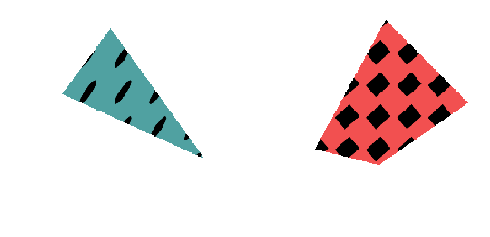

Distance between #3 and #10: 169.94


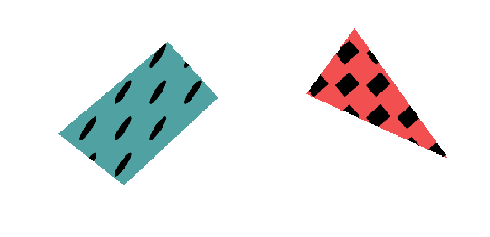

In [55]:
df_sorted = df_s.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:5]:
    show_pair(imgs_s[0], imgs_s[1], df_sorted, k)
print('\n\n\n........\n\n\n')
for k in inds[-5:]:
    show_pair(imgs_s[0], imgs_s[1], df_sorted, k)

## Parametrically vary color

In [56]:
imgs_c, df_c, biases_c, similarities_c = run_experiment(model, 20, target_feature='color', others_constant=False)

In [57]:
lr = LinearRegression()
lr.fit(similarities_c.reshape(-1,1), biases_c)
x_grid = np.linspace(0, 1).reshape(-1,1)
y_grid = lr.predict(x_grid)

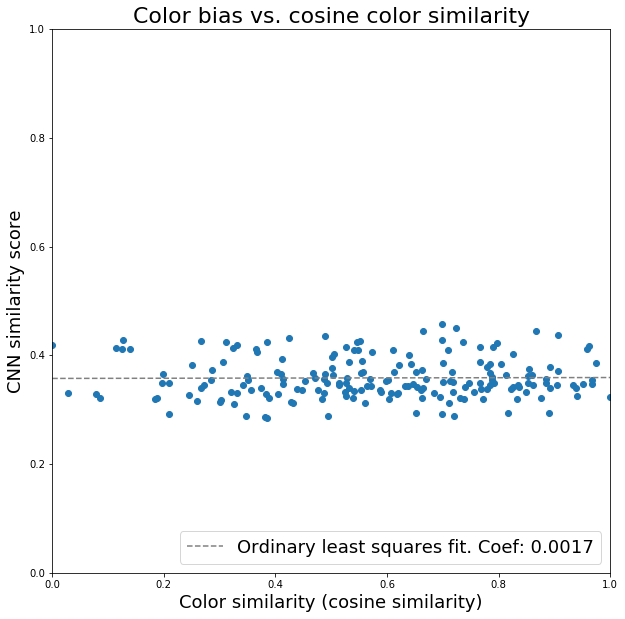

In [58]:
# Plot results
plt.figure(figsize=(10, 10))
plt.scatter(similarities_c, biases_c)
plt.plot(x_grid, y_grid, '--', color='grey', label='Ordinary least squares fit. Coef: %0.4f' % lr.coef_[0])
plt.title('Color bias vs. cosine color similarity', fontsize=22)
plt.xlabel('Color similarity (cosine similarity)', fontsize=18)
plt.ylabel('CNN similarity score', fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=18)
plt.show()

In [ ]:
df_sorted = df_c.sort_values(by='score')
inds = list(range(len(df_sorted)))
for k in inds[:5]:
    show_pair(imgs_c[0], imgs_c[1], df_sorted, k)
print('\n\n\n........\n\n\n')
for k in inds[-5:]:
    show_pair(imgs_c[0], imgs_c[1], df_sorted, k)